In [147]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from glob import glob
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from joblib import Parallel, delayed

from matplotlib.font_manager import FontProperties

# from simulate_radiances_utils import *
%run simulate_radiances_utils.py
import urllib 

In [2]:
data_dir =  '/export/data2/groupMembers/cchristo/'
raw_aeri_data_dir = data_dir + 'aeri/aeri_noise_filtered/summit/'

In [3]:
file_paths = os.listdir(raw_aeri_data_dir)

In [173]:
ds_i = xr.open_dataset(raw_aeri_data_dir + file_paths[300])
ds_i_time = ds_i.isel(time = 0)

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [190]:
# ds_i.attrs

In [185]:
for var_name in ds_i.variables:
    try:
        print(var_name +  ' : ' + ds_i[var_name].attrs['longname'])
    except: 
        pass

base_time : Base time in Epoch
wnum : Wave number in reciprocal centimeters
time_offset : Time offset from base_time
missingDataFlag : Logical flag indicating that a data record is missing (true/false)
sceneMirPosEncoderMaxDrift : Maximum departure from ideal of the mirror position over the course of all contributing views.  Typically two hot, two ambient, and one scene view are examined.
BBcavityFactor : Blackbody cavity geometry factor
HBBtempOffset : Corrective offset for final hot blackbody average temperature
ABBtempOffset : Corrective offset for final ambient blackbody average temperature
HBBbottomTempWeight : Weight factor for bottom used in calculating hot blackbody temperature average
HBBapexTempWeight : Weight factor for apex used in calculating hot blackbody temperature average
HBBtopTempWeight : Weight factor for top used in calculating hot blackbody temperature average
ABBbottomTempWeight : Weight factor for bottom used in calculating ambient blackbody temperature average


In [187]:
# ds_i['sceneMirrorPosition']

<xarray.DataArray 'sceneMirrorPosition' (time: 3352)>
array([83., 84., 85., ..., 88., 89., 90.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-04-17T00:03:42 ... 2011-04-17T23:56:32
Attributes:
    longname:   Instrument scene mirror position identifier
    units:      count
    precision:  1E0

In [52]:
file_paths_sub = [raw_aeri_data_dir + fname for fname in file_paths if '201501' in fname][:7]

In [82]:
ds_1 = xr.open_dataset(file_paths_sub[0])
ds_2 = xr.open_dataset(file_paths_sub[0])
# ds_i_time = ds_i.isel(time = 0)

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [101]:
ds_1 #['mean_rad']
ds_1['time_offset']

<xarray.DataArray 'time_offset' (time: 3312)>
array(['2015-01-01T00:03:40.000000000', '2015-01-01T00:03:55.000000000',
       '2015-01-01T00:04:15.000000000', ..., '2015-01-01T23:55:36.000000000',
       '2015-01-01T23:55:56.000000000', '2015-01-01T23:56:16.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time
Attributes:
    longname:  Time offset from base_time

In [172]:
ds_i

<xarray.Dataset>
Dimensions:   (time: 23384, wnum: 2714)
Coordinates:
  * wnum      (wnum) float64 491.8 492.3 492.8 ... 1.799e+03 1.799e+03 1.8e+03
  * time      (time) datetime64[ns] 2015-01-01T00:03:40 ... 2015-01-07T23:57:11
Data variables:
    mean_rad  (time, wnum) float64 dask.array<chunksize=(3312, 2714), meta=np.ndarray>

In [115]:
def preprocess_spectra_ds(ds):
    time_offset = ds['time_offset']
#     base_time = ds['base_time']
    ds_subset = ds['mean_rad'].to_dataset()
    ds_subset = ds_subset.assign_coords({'time':time_offset})
    return ds_subset

In [109]:
# preprocess_spectra_ds(ds_2)
ds_2['time_offset']

<xarray.DataArray 'time_offset' (time: 3312)>
array(['2015-01-01T00:03:40.000000000', '2015-01-01T00:03:55.000000000',
       '2015-01-01T00:04:15.000000000', ..., '2015-01-01T23:55:36.000000000',
       '2015-01-01T23:55:56.000000000', '2015-01-01T23:56:16.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time
Attributes:
    longname:  Time offset from base_time

In [117]:
ds_i = xr.open_mfdataset(file_paths_sub, 
                         combine = 'by_coords',
                         concat_dim = 'time', 
                         preprocess=preprocess_spectra_ds)

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  cond

In [169]:
ds_i_nan = ds_i.where(ds_i > 0, np.nan)
ds_i_time_max = ds_i_nan.max('time')
ds_i_time_min = ds_i_nan.min('time')
ds_i_time_median = ds_i_nan.median('time')

In [136]:
# k_grid.ma
# ds_i_time
# ds_i_time['mean_rad'].values
# ds_i['mean_rad']


<xarray.Dataset>
Dimensions:   (time: 23384, wnum: 2714)
Coordinates:
  * wnum      (wnum) float64 491.8 492.3 492.8 ... 1.799e+03 1.799e+03 1.8e+03
  * time      (time) datetime64[ns] 2015-01-01T00:03:40 ... 2015-01-07T23:57:11
Data variables:
    mean_rad  (time, wnum) float64 dask.array<chunksize=(3312, 2714), meta=np.ndarray>

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Text(0.5, 1.0, 'Downwelling Thermal Radiance in Nadir at surface')

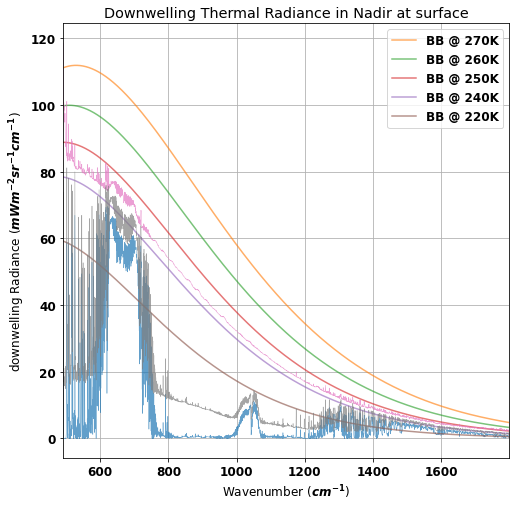

In [170]:
plt.figure(figsize = (8,8))
# ds_i
k_grid = ds_i_time['wnum'].values
rad = ds_i_time_min['mean_rad'].values
plt.plot(k_grid, rad, linewidth = 0.5, alpha=0.7)



wavenum_m = k_grid*1e2
W_m_mW_cm = 1e2*1e3
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,270),label='BB @ 270K',alpha=0.63)
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,260),label='BB @ 260K',alpha=0.63)
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,250),label='BB @ 250K',alpha=0.63)
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,240),label='BB @ 240K',alpha=0.63)
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,220),label='BB @ 220K',alpha=0.63)
plt.legend(loc=0)

k_grid = ds_i_time['wnum'].values
rad = ds_i_time_max['mean_rad'].values
plt.plot(k_grid, rad, linewidth = 0.5,alpha=0.7)


k_grid = ds_i_time['wnum'].values
rad = ds_i_time_median['mean_rad'].values
plt.plot(k_grid, rad, linewidth = 0.5,alpha=0.7)

plt.xlim((491,1799))

plt.grid()
plt.xlabel('Wavenumber ($cm^{-1}$)')
plt.ylabel(r'downwelling Radiance ($mW m^{-2} sr^{-1} cm^{-1}$)')
plt.title('Downwelling Thermal Radiance in Nadir at surface')

In [140]:
standard_dev_rad = ds_i_time['standard_dev_mean_rad'].values
k_grid2 = ds_i_time['wnum2'].values

KeyError: 'standard_dev_mean_rad'

Text(0, 0.5, 'Radiance STD')

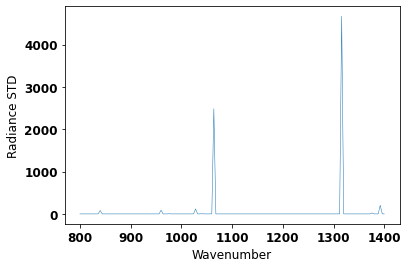

In [25]:
plt.plot(k_grid2, standard_dev_rad, linewidth = 0.5)

plt.xlabel('Wavenumber')
plt.ylabel('Radiance STD')